# Дополнительны модули, которые нужно установить

In [1]:
%pip install category_encoders
%pip install scikit-plot 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Импорты

In [2]:
import pickle 
import scikitplot as skplt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
from datetime import date
from scipy.stats import zscore
from collections import Counter
from sklearn.metrics import confusion_matrix, matthews_corrcoef, f1_score

from matplotlib.pyplot import hist

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import category_encoders as ce
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# EDA Разведочный анализ данных 

## Загрузка датасета

In [3]:
#Расскоментируйте тот способ загрузки данных, какой хотите, с гитхаба, с Google drive, или с локальной папки с этим ipynb файлом
ds = pd.read_csv('https://github.com/triesonyk/data-analysis-steam-games/blob/master/steam_games.csv?raw=true')

# ds = pd.read_csv('steam_games.csv')

# from google.colab import drive
# drive.mount('/content/drive')
# ds = pd.read_csv('content/drive/[Path to the folder with dataset]/steam_games.csv')

ds.head().T

,0,1,2,3,4
title,Apex Legends™,God of War,ELDEN RING,Grand Theft Auto V,Forza Horizon 5
url,https://store.steampowered.com/app/1172470/Ape...,https://store.steampowered.com/app/1593500/God...,https://store.steampowered.com/app/1245620/ELD...,https://store.steampowered.com/app/271590/Gran...,https://store.steampowered.com/app/1551360/For...
image,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...
release_date,"4 Nov, 2020","14 Jan, 2022","24 Feb, 2022","13 Apr, 2015","8 Nov, 2021"
platforms,Windows,Windows,Windows,Windows,Windows
discount_rate,NaN,-20%,NaN,NaN,-20%
original_price,Free to Play,Rp 729 000,Rp 599 000,NaN,Rp 699 000
discounted_price,NaN,Rp 583 200,NaN,NaN,Rp 559 200
developer,Respawn Entertainment,Santa Monica Studio,FromSoftware Inc.,Rockstar North,Playground Games
publisher,Electronic Arts,PlayStation PC LLC,"FromSoftware Inc.,Bandai Namco Entertainment",Rockstar Games,Xbox Game Studios


## Описательный анализ и обработка датасета

In [4]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121904 entries, 0 to 121903
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   title             121893 non-null  object 
 1   url               121904 non-null  object 
 2   image             121904 non-null  object 
 3   release_date      113850 non-null  object 
 4   platforms         117576 non-null  object 
 5   discount_rate     2941 non-null    object 
 6   original_price    109675 non-null  object 
 7   discounted_price  2935 non-null    object 
 8   developer         113921 non-null  object 
 9   publisher         103890 non-null  object 
 10  overall_reviews   78125 non-null   object 
 11  recent_reviews    78125 non-null   object 
 12  whole_reviews     5773 non-null    object 
 13  description       75925 non-null   object 
 14  tags              112020 non-null  object 
 15  genre             111334 non-null  object 
 16  processor         10

In [5]:
#Для удобства, сохраним изначальный датасет в отдельной переменной, работать дальше будем с копией
dsn = ds.copy(deep = True)

In [6]:
#Функция для более удобного удаления рядов из датасета
def drop_rows(ds, rows):
  ds.drop(rows.index, inplace = True)
  ds.reset_index(drop=True, inplace=True)

In [7]:
#Так как нам не нужны игры без тагов, давайте их все удалим
dsn.dropna(inplace=True, subset=["tags"])
dsn.reset_index(drop=True, inplace=True)
dsn[dsn.tags.isna()].shape[0]

0

In [8]:
dsn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112020 entries, 0 to 112019
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   title             112013 non-null  object 
 1   url               112020 non-null  object 
 2   image             112020 non-null  object 
 3   release_date      111265 non-null  object 
 4   platforms         109902 non-null  object 
 5   discount_rate     2159 non-null    object 
 6   original_price    99965 non-null   object 
 7   discounted_price  2153 non-null    object 
 8   developer         111676 non-null  object 
 9   publisher         101909 non-null  object 
 10  overall_reviews   77128 non-null   object 
 11  recent_reviews    77128 non-null   object 
 12  whole_reviews     5773 non-null    object 
 13  description       75875 non-null   object 
 14  tags              112020 non-null  object 
 15  genre             111321 non-null  object 
 16  processor         10

In [9]:
#Как видим, столбцы с тагами у нас представляют строки, где таги пречислены через запятую
#Порядок тагов важен для ранжирования в поиске в steam, однако после первых 5 тагов он уже не так важен
#В дальнейшем мы будем ориентироваться на комбинации из не более чем 3 тагов для подачи в нашу модель 
dsn.tags[0]

'Free to Play,Battle Royale,Multiplayer,Shooter,First-Person,FPS,PvP,Action,Hero Shooter,Team-Based,Tactical,Survival,Character Customization,Sci-fi,Funny,Loot,Lore-Rich,Cyberpunk,Co-op,Cinematic'

In [10]:
#Создадим 2 новых столбца, tags_list - наши строки с тагами преобразованные в массивы тагов 
dsn["tags_list"] = dsn.tags.apply(lambda x: x.split(','))
#tags_count - количество тагов на одну игру
dsn["tags_count"] = dsn.tags_list.apply(lambda x: len(x))

In [11]:
dsn.tags_count.describe()

count    112020.000000
mean         10.080227
std           7.168494
min           1.000000
25%           3.000000
50%           8.000000
75%          19.000000
max          20.000000
Name: tags_count, dtype: float64

In [12]:
dsn.tags_list[0]

['Free to Play',
 'Battle Royale',
 'Multiplayer',
 'Shooter',
 'First-Person',
 'FPS',
 'PvP',
 'Action',
 'Hero Shooter',
 'Team-Based',
 'Tactical',
 'Survival',
 'Character Customization',
 'Sci-fi',
 'Funny',
 'Loot',
 'Lore-Rich',
 'Cyberpunk',
 'Co-op',
 'Cinematic']

In [13]:
#Так как нам необходимо чтобы 3 тага у игр присутствовали обязательно, удалим все игры
#где их меньше
print(f"Количество игр с < 3 количеством тагов до удаления {dsn[dsn.tags_count < 3].shape[0]}")
drop_rows(dsn,dsn[dsn.tags_count < 3])
print(f"Количество игр с < 3 количеством тагов после {dsn[dsn.tags_count < 3].shape[0]}")

Количество игр с < 3 количеством тагов до удаления 18511
Количество игр с < 3 количеством тагов после 0


In [14]:
#Создадим список всех списков первых 3-х тагов всех игр
all_tags = []

for tag_list in dsn.tags_list:
  all_tags += tag_list[:3]

len(all_tags), dsn.tags_count.sum()

(280527, 1100706)

In [15]:
#Удалим все дупликаты из него
all_tags = list(set(all_tags))
len(all_tags)

424

In [16]:
#Взглянем что там у нас за таги
all_tags[:5]

['Multiple Endings', 'Sokoban', 'Gaming', 'Voxel', 'Time Attack']

In [17]:
#Удалим непристойные таги
K = ['LGBTQ+', 'Hentai', 'NSFW']
for k in K:
  all_tags = [i for i in all_tags if i != k]

for k in K:
  print(k in all_tags)

False
False
False


In [18]:
#Дропнем все эти непотребства :)
print(f"Shape перед удалением {dsn.shape}")

print(f"Количество игр с тагом NSFW перед удалением: {dsn[['NSFW' in l for l in dsn.tags_list.to_list()]].shape}")
print(f"Количество игр с тагом LGBTQ+ перед удалением: {dsn[['LGBTQ+' in l for l in dsn.tags_list.to_list()]].shape}")
print(f"Количество игр с тагом Hentai перед удалением: {dsn[['Hentai' in l for l in dsn.tags_list.to_list()]].shape}")

drop_rows(dsn, dsn[['NSFW' in l for l in dsn.tags_list.to_list()]])
drop_rows(dsn, dsn[['LGBTQ+' in l for l in dsn.tags_list.to_list()]])
drop_rows(dsn, dsn[['Hentai' in l for l in dsn.tags_list.to_list()]])

print('\n')

print(f"Количество игр с тагом NSFW после удаления: {dsn[['NSFW' in l for l in dsn.tags_list.to_list()]].shape}")
print(f"Количество игр с тагом LGBTQ+ после удаления: {dsn[['LGBTQ+' in l for l in dsn.tags_list.to_list()]].shape}")
print(f"Количество игр с тагом Hentai после удаления: {dsn[['Hentai' in l for l in dsn.tags_list.to_list()]].shape}")

print(f"Shape после удаления {dsn.shape}")

Shape перед удалением (93509, 24)
Количество игр с тагом NSFW перед удалением: (390, 24)
Количество игр с тагом LGBTQ+ перед удалением: (1321, 24)
Количество игр с тагом Hentai перед удалением: (612, 24)


Количество игр с тагом NSFW после удаления: (0, 24)
Количество игр с тагом LGBTQ+ после удаления: (0, 24)
Количество игр с тагом Hentai после удаления: (0, 24)
Shape после удаления (91492, 24)


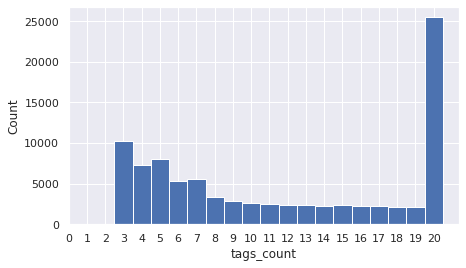

In [19]:
#Посмотрим как распределено количество наших тагов
sns.set(rc={'figure.figsize':(7,4)})
g = sns.histplot(dsn.tags_count, bins = 20, discrete=True, alpha=1)
g.set_xticks(range(0, 21))

In [20]:
#Для оценки "успешности" игры, нам понадобится подсчитать количество ревью для каждой игры
#Платформа steam не показывает нам продажи, однако, она показывает общее количество ревью, оставленных человеком на игру
#Это поможет нам предсказать количество общих продаж, которое считается как примерно 50*(общее количество ревью)
#Посмотрим что там у нас в поле whole_reviews
dsn.whole_reviews[0]

'- 86% of the 469,045 user reviews for this game are positive.'

In [21]:
#Нас интересует число 469,045, которое явлется числом всех когда либо оставленных ревью на игру людьми
#Нас не интересуют игры без ревью, давайте взглянем сколько у нас игр с ревью в датасете
print(f"Количество игр с ревью {dsn[dsn.whole_reviews.notna()].shape[0]}")
print(f"Количество игр без ревью {dsn[dsn.whole_reviews.isna()].shape[0]}")

Количество игр с ревью 5420
Количество игр без ревью 86072


In [22]:
#К сожалению нам прийдется удалить большую часть датасета
dsn.dropna(subset=["whole_reviews"],inplace=True)
dsn.reset_index(drop=True, inplace=True)
print(f"Количество игр с ревью после удаления {dsn[dsn.whole_reviews.notna()].shape[0]}")
print(f"Количество игр без ревью после удаления {dsn[dsn.whole_reviews.isna()].shape[0]}")

Количество игр с ревью после удаления 5420
Количество игр без ревью после удаления 0


In [23]:
#Проверим на всякий что все ревью у нас являются строками
dsn[dsn.whole_reviews.apply(lambda x: isinstance(x, str))].shape[0]

5420

In [24]:
dsn.whole_reviews.info()

<class 'pandas.core.series.Series'>
RangeIndex: 5420 entries, 0 to 5419
Series name: whole_reviews
Non-Null Count  Dtype 
--------------  ----- 
5420 non-null   object
dtypes: object(1)
memory usage: 42.5+ KB


In [25]:
#Вычленим при помощи регулярных выражений наше число всех ревью для каждой игры,
#И запишем их в новый столбец reviews_count
dsn['reviews_count'] = [int(n[1]) for n in dsn.whole_reviews.apply(lambda x: re.findall(r'\d+',x.replace(',', '')))]
dsn[['whole_reviews', 'reviews_count']].head(), dsn.reviews_count.dtype

(                                       whole_reviews  reviews_count
 0  - 86% of the 469,045 user reviews for this gam...         469045
 1  - 97% of the 34,533 user reviews for this game...          34533
 2  - 90% of the 381,880 user reviews for this gam...         381880
 3  - 85% of the 1,226,760 user reviews for this g...        1226760
 4  - 87% of the 70,919 user reviews for this game...          70919,
 dtype('int64'))

In [26]:
# опишем нашу новую метрику
dsn.reviews_count.describe().round(2)

count       5420.00
mean       13010.78
std       104237.52
min           10.00
25%          780.75
50%         2228.00
75%         6669.75
max      6464937.00
Name: reviews_count, dtype: float64

In [27]:
# Для нас бесполезны игры, у которых полностью совпадают как первые 3 тага так и количество ревью
# так как мы будем подавать в модель исключительно набор тагов и кол-во ревью, для нас это дупликаты
# удалим такие игры
dupl_ds = dsn.copy()
#Проверим как они выглядят
dupl_ds['dupl_check'] =  dupl_ds.tags_list.apply(lambda x: ''.join(sorted(x[:3])))
dupl_ds[dupl_ds.duplicated(subset=['dupl_check','reviews_count'],keep=False)][['reviews_count', 'dupl_check']].sort_values(by='dupl_check' ,ascending=False)

,reviews_count,dupl_check
2794,203,StrategyWarWorld War II
3577,203,StrategyWarWorld War II
3669,112856,StrategyTurn-BasedTurn-Based Strategy
5316,112856,StrategyTurn-BasedTurn-Based Strategy
5283,74015,StrategyTower DefenseZombies
...,...,...
4008,54,2D PlatformerActionPixel Graphics
3726,279,2.5DFPSOld School
4365,279,2.5DFPSOld School
3115,1132,1990'sAdventurePixel Graphics


In [28]:
#Удаляем дупликаты
drop_rows(dsn, dupl_ds[dupl_ds.duplicated(subset=['dupl_check','reviews_count'])].sort_values(by='dupl_check'))

In [29]:
dsn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             4754 non-null   object 
 1   url               4754 non-null   object 
 2   image             4754 non-null   object 
 3   release_date      4741 non-null   object 
 4   platforms         4754 non-null   object 
 5   discount_rate     222 non-null    object 
 6   original_price    4701 non-null   object 
 7   discounted_price  222 non-null    object 
 8   developer         4751 non-null   object 
 9   publisher         4720 non-null   object 
 10  overall_reviews   4754 non-null   object 
 11  recent_reviews    4754 non-null   object 
 12  whole_reviews     4754 non-null   object 
 13  description       4590 non-null   object 
 14  tags              4754 non-null   object 
 15  genre             4747 non-null   object 
 16  processor         4558 non-null   object 


In [30]:
#Проверим на дупликаты еще раз
dupl_ds = dsn.copy()
dupl_ds['dupl_check'] =  dupl_ds.tags_list.apply(lambda x: ''.join(sorted(x[:3])))
dupl_ds[dupl_ds.duplicated(subset=['dupl_check','reviews_count'],keep=False)].sort_values(by='dupl_check' ,ascending=False)

,title,url,image,release_date,platforms,discount_rate,original_price,discounted_price,developer,publisher,...,processor,ram,graphic_card,rating,language,metacriticts,tags_list,tags_count,reviews_count,dupl_check


In [31]:
#Для оценки успешности игры, будем использовать метрику ((общее количество ревью)/(количество дней с момента выхода игры))*30
#Что даст нам количество оставленных ревью в месяц
#Сначала взглянем, что там у нас в дате
dsn.release_date[:5]

0     4 Nov, 2020
1    14 Jan, 2022
2    24 Feb, 2022
3    13 Apr, 2015
4     8 Nov, 2021
Name: release_date, dtype: object

In [32]:
#Как видим опять строки, опять прийдется парсить
#Но сначала проверим на Null
dsn[dsn.release_date.isna()].shape[0]

13

In [33]:
#Не так уж и много, удалим
dsn.dropna(subset=["release_date"],inplace=True)
dsn.reset_index(drop=True, inplace=True)

dsn[dsn.release_date.isna()].shape[0]

0

<Axes: ylabel='Count'>

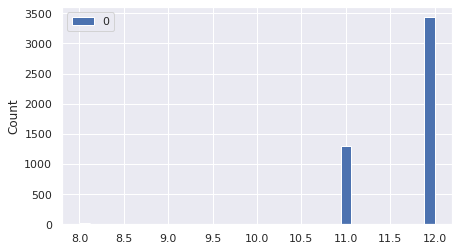

In [34]:
#Преобразуем нашу дату релиза в новые столбцы, год, день, месяц и количество дней с момента релиза
#Перед обработкой строк с данными, посмотрим вс ели они одинаковы по длине
rel_date_len = pd.DataFrame([len(n) for n in dsn.release_date])
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(rel_date_len, alpha=1)

In [35]:
#Проверим есть ли строки с датами меньше 11
short_dates = dsn.release_date[dsn.release_date.str.len() < 11]
short_dates

380     Nov 2020
410     Aug 2018
618     Nov 2014
686     Dec 2016
2028    Aug 2015
2117    Feb 2021
2760    Jul 2014
2920    Mar 2020
3335    Aug 2013
3350    Dec 2019
3353    Jan 2016
3650    Aug 2017
3726    Jan 2019
4377    Jan 2021
Name: release_date, dtype: object

In [36]:
#Действительно есть, получается мы не знаем точный день выхода этих игр
#Мы просто установим его как 1 тогда
short_date_indxs = short_dates.index
short_date_indxs

for indx in short_date_indxs:
  dsn.release_date.at[indx] = "1 " + dsn.release_date.iloc[indx]

dsn.release_date.iloc[short_date_indxs], dsn.release_date.iloc[short_date_indxs].str.len()

(380     1 Nov 2020
 410     1 Aug 2018
 618     1 Nov 2014
 686     1 Dec 2016
 2028    1 Aug 2015
 2117    1 Feb 2021
 2760    1 Jul 2014
 2920    1 Mar 2020
 3335    1 Aug 2013
 3350    1 Dec 2019
 3353    1 Jan 2016
 3650    1 Aug 2017
 3726    1 Jan 2019
 4377    1 Jan 2021
 Name: release_date, dtype: object, 380     10
 410     10
 618     10
 686     10
 2028    10
 2117    10
 2760    10
 2920    10
 3335    10
 3350    10
 3353    10
 3650    10
 3726    10
 4377    10
 Name: release_date, dtype: int64)

In [37]:
#Длина эих новых строк 10 так как нет запятой после месяца, но это не страшно, к обработке они пригодны
#Разобьем даты на составляющие, и преобразуем каждую в массив строк
release_date_list = []

for i in range(0, dsn.shape[0]):  
  release_date_list.append(dsn.release_date.iloc[i].replace(',', '').split(' '))

release_date_list[:5]

[['4', 'Nov', '2020'],
 ['14', 'Jan', '2022'],
 ['24', 'Feb', '2022'],
 ['13', 'Apr', '2015'],
 ['8', 'Nov', '2021']]

In [38]:
#Теперь преобразуем это все в числа, для этого нам понадобится маппинг от слов с месяцами к числам
#Заодно преобразуем все в int
def get_month_int(date):
  if date == 'Sep':
    return 9
  if date == 'Oct':
    return 10
  if date == 'Nov':
    return 11
  if date == 'Dec':
    return 12
  if date == 'Jan':
    return 1
  if date == 'Feb':
    return 2
  if date == 'Mar':
    return 3
  if date == 'Apr':
    return 4
  if date == 'May':
    return 5
  if date == 'Jun':
    return 6
  if date == 'Jul':
    return 7
  if date == 'Aug':
    return 8

for i in range(0, len(release_date_list)):
  release_date_list[i][0] = int(release_date_list[i][0])
  release_date_list[i][1] = get_month_int(release_date_list[i][1])
  release_date_list[i][2] = int(release_date_list[i][2])

release_date_list[:5]

[[4, 11, 2020], [14, 1, 2022], [24, 2, 2022], [13, 4, 2015], [8, 11, 2021]]

In [39]:
#Теперь для дня месяца и года создадим отдельный численный столбец в датасете
zeros = np.zeros(shape=(dsn.release_date.shape[0], 1),dtype=int)
dsn['release_day'] = zeros
dsn['release_month'] = zeros
dsn['release_year'] = zeros

for i in range(0, dsn.shape[0]):
  dsn['release_day'].at[i] = release_date_list[i][0]
  dsn['release_month'].at[i] = release_date_list[i][1]
  dsn['release_year'].at[i] = release_date_list[i][2]

rel = dsn[['release_date','release_day', 'release_month','release_year']]
rel

,release_date,release_day,release_month,release_year
0,"4 Nov, 2020",4,11,2020
1,"14 Jan, 2022",14,1,2022
2,"24 Feb, 2022",24,2,2022
3,"13 Apr, 2015",13,4,2015
4,"8 Nov, 2021",8,11,2021
...,...,...,...,...
4736,"22 May, 2017",22,5,2017
4737,"13 May, 2020",13,5,2020
4738,"25 Mar, 2013",25,3,2013
4739,"17 May, 2022",17,5,2022


In [40]:
dsn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4741 entries, 0 to 4740
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             4741 non-null   object 
 1   url               4741 non-null   object 
 2   image             4741 non-null   object 
 3   release_date      4741 non-null   object 
 4   platforms         4741 non-null   object 
 5   discount_rate     222 non-null    object 
 6   original_price    4692 non-null   object 
 7   discounted_price  222 non-null    object 
 8   developer         4738 non-null   object 
 9   publisher         4707 non-null   object 
 10  overall_reviews   4741 non-null   object 
 11  recent_reviews    4741 non-null   object 
 12  whole_reviews     4741 non-null   object 
 13  description       4577 non-null   object 
 14  tags              4741 non-null   object 
 15  genre             4734 non-null   object 
 16  processor         4546 non-null   object 


In [41]:
#Ну а теперь создадим метод, который выдаст нам все игры между двумя датами 
def between_dates(data, from_day, from_month, from_year, to_day, to_month, to_year):
  filtered_by_year = dsn[(dsn.release_year >= from_year) & (dsn.release_year <= to_year)]
  filtered_by_month = filtered_by_year[(filtered_by_year.release_month >= from_month) & (filtered_by_year.release_month <= to_month)]
  filtered_by_day = filtered_by_month[(filtered_by_month.release_day >= from_day) & (filtered_by_month.release_day <= to_day)]
  return filtered_by_day

between_dates(dsn, 1, 1, 2021, 30, 6, 2022)[['release_day', 'release_month','release_year']].sort_values(['release_year', 'release_month', 'release_day'], ascending=False)

,release_day,release_month,release_year
221,21,6,2022
9,20,6,2022
4541,19,6,2022
1293,17,6,2022
3191,17,6,2022
...,...,...,...
910,8,1,2021
3800,7,1,2021
1319,5,1,2021
3629,5,1,2021


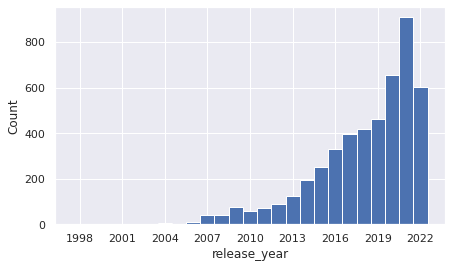

In [42]:
#Посмотрим как распределены игры по годам выхода
sns.set(rc={'figure.figsize':(7,4)})
g = sns.histplot(dsn.release_year, alpha=1, bins= dsn.release_year.max() - dsn.release_year.min(), discrete=True)
g.set_xticks(range(dsn.release_year.min(), dsn.release_year.max()+1, 3))

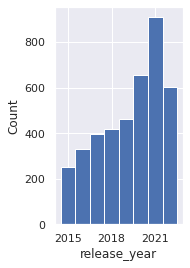

In [43]:
#Протестируем наш метод, выберем все игры от 1 дня 2015 года
sns.set(rc={'figure.figsize':(2.3,4)})
g = sns.histplot(between_dates(dsn, 1, 1, 2015, 31, 12, 2022).release_year, alpha=1, bins= dsn.release_year.max() - 2015, discrete=True)
g.set_xticks(range(2015, dsn.release_year.max()+1, 3))

In [44]:
#Убедимся что наша функция возвращает правильные элементы
(dsn[(dsn.release_year >= 2015) & (dsn.release_year <= 2022)].release_year == between_dates(dsn, 1, 1, 2015, 31, 12, 2022).release_year).all()

True

In [45]:
#Расчитаем для каждой игры количество дней с момента выхода и создадим новую колонку с этим значением для каждой игры
max_date = dsn[['release_year', 'release_month', 'release_day']].sort_values(['release_year', 'release_month', 'release_day'], ascending=False).iloc[0].to_numpy()

def days_between_dates(from_year, from_month, from_day, to_year, to_month, to_day):
  d0 = date(from_year, from_month, from_day)
  d1 = date(to_year, to_month, to_day)
  delta = d1 - d0
  return int(delta.days)

dsn["days_since_release"] = np.zeros(dsn.shape[0])

i = 0 
for d in dsn[['release_day', 'release_month', 'release_year']].to_numpy():
  dsn["days_since_release"].at[i] = days_between_dates(d[2], d[1], d[0], max_date[0], max_date[1], max_date[2])
  i += 1
dsn['days_since_release']

0        594.0
1        158.0
2        117.0
3       2626.0
4        225.0
         ...  
4736    1856.0
4737     769.0
4738    3375.0
4739      35.0
4740    3591.0
Name: days_since_release, Length: 4741, dtype: float64

In [46]:
#Преобразуем в int
dsn["days_since_release"] = dsn["days_since_release"].astype(int)
dsn["days_since_release"]

0        594
1        158
2        117
3       2626
4        225
        ... 
4736    1856
4737     769
4738    3375
4739      35
4740    3591
Name: days_since_release, Length: 4741, dtype: int64

In [47]:
#Сравним с нашей датой
dsn[['release_day', 'release_month', 'release_year', 'days_since_release']]

,release_day,release_month,release_year,days_since_release
0,4,11,2020,594
1,14,1,2022,158
2,24,2,2022,117
3,13,4,2015,2626
4,8,11,2021,225
...,...,...,...,...
4736,22,5,2017,1856
4737,13,5,2020,769
4738,25,3,2013,3375
4739,17,5,2022,35


In [48]:
#Опишем наше новое значение
dsn.days_since_release.describe().to_frame()

,days_since_release
count,4741.000000
mean,1424.570344
std,1310.662908
min,0.000000
25%,377.000000
50%,1050.000000
75%,2119.000000
max,8626.000000


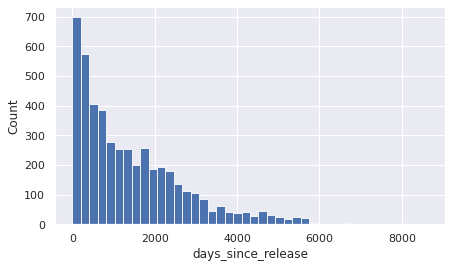

In [49]:
#Построим гистограмму
sns.set(rc={'figure.figsize':(7,4)})
g = sns.histplot(dsn.days_since_release, alpha=1)

In [50]:
#Можно сказать, что новых игр гораздно больше чем старых в датасете
#Давайте удалим все игры, которые имеют 0 дней с момента релиза, так как
#мы не сможем расчитать для них наш показатель количество полученных ревью за 30 дней
drop_rows(dsn,dsn[dsn.days_since_release == 0])
dsn.days_since_release.describe().to_frame()

,days_since_release
count,4740.000000
mean,1424.870886
std,1310.637793
min,1.000000
25%,377.000000
50%,1050.000000
75%,2119.250000
max,8626.000000


In [51]:
#Приведем к инт
dsn['days_since_release'] = dsn.days_since_release.astype(int)
dsn.days_since_release.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4740 entries, 0 to 4739
Series name: days_since_release
Non-Null Count  Dtype
--------------  -----
4740 non-null   int64
dtypes: int64(1)
memory usage: 37.2 KB


In [52]:
#Все, теперь минимум дней с момента релиза у нас 1, проверим над датасет
dsn.shape

(4740, 29)

In [53]:
dsn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4740 entries, 0 to 4739
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               4740 non-null   object 
 1   url                 4740 non-null   object 
 2   image               4740 non-null   object 
 3   release_date        4740 non-null   object 
 4   platforms           4740 non-null   object 
 5   discount_rate       221 non-null    object 
 6   original_price      4691 non-null   object 
 7   discounted_price    221 non-null    object 
 8   developer           4737 non-null   object 
 9   publisher           4706 non-null   object 
 10  overall_reviews     4740 non-null   object 
 11  recent_reviews      4740 non-null   object 
 12  whole_reviews       4740 non-null   object 
 13  description         4576 non-null   object 
 14  tags                4740 non-null   object 
 15  genre               4733 non-null   object 
 16  proces

In [54]:
dsn.head().T

,0,1,2,3,4
title,Apex Legends™,God of War,ELDEN RING,Grand Theft Auto V,Forza Horizon 5
url,https://store.steampowered.com/app/1172470/Ape...,https://store.steampowered.com/app/1593500/God...,https://store.steampowered.com/app/1245620/ELD...,https://store.steampowered.com/app/271590/Gran...,https://store.steampowered.com/app/1551360/For...
image,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...,https://cdn.akamai.steamstatic.com/steam/apps/...
release_date,"4 Nov, 2020","14 Jan, 2022","24 Feb, 2022","13 Apr, 2015","8 Nov, 2021"
platforms,Windows,Windows,Windows,Windows,Windows
discount_rate,NaN,-20%,NaN,NaN,-20%
original_price,Free to Play,Rp 729 000,Rp 599 000,NaN,Rp 699 000
discounted_price,NaN,Rp 583 200,NaN,NaN,Rp 559 200
developer,Respawn Entertainment,Santa Monica Studio,FromSoftware Inc.,Rockstar North,Playground Games
publisher,Electronic Arts,PlayStation PC LLC,"FromSoftware Inc.,Bandai Namco Entertainment",Rockstar Games,Xbox Game Studios


In [55]:
# Проверим на дупликаты исключительно по первым 3-м тагам
dupl_ds = dsn.copy()
dupl_ds['dupl_check'] =  dupl_ds.tags_list.apply(lambda x: ''.join(sorted(x[:3])))
dupl_ds[dupl_ds.duplicated(subset=['dupl_check'],keep=False)][['reviews_count','days_since_release','dupl_check']].sort_values(by='dupl_check' ,ascending=False)

,reviews_count,days_since_release,dupl_check
1639,5275,784,StrategyTurn-BasedTurn-Based Tactics
626,3188,1296,StrategyTurn-BasedTurn-Based Tactics
4633,56957,2329,StrategyTurn-BasedTurn-Based Strategy
2077,3875,5718,StrategyTurn-BasedTurn-Based Strategy
3435,112856,4291,StrategyTurn-BasedTurn-Based Strategy
...,...,...,...
2109,146,733,2D FighterActionFighting
867,4333,265,2D FighterActionAnime
1345,2566,944,2D FighterActionAnime
4632,4687,830,2D FighterActionAnime


In [56]:
  #Как видим количество ревью у нас разное, однако первые 3 тага точно таки же
#Что помешает нам проследить взаимосвязь между ревью и тагами в изоляции
#Поэтому удалим все такие игры, чтобы все комбинации тагов в датасете были уникальны
#А количество ревью и дней с момента выхода игры для единственной оставшейся записи-не дубликата,
# сделаем как среднее между ним и удаленными дупликатами
dup_sums = dupl_ds[dupl_ds.duplicated(subset=['dupl_check'],keep=False)].sort_values(by='dupl_check' ,ascending=False).groupby(['dupl_check']).sum()
tag_duplicats = dupl_ds[dupl_ds.duplicated(subset=['dupl_check'],keep=False)].sort_values(by='dupl_check' ,ascending=False)
tag_duplicats_count = dupl_ds[dupl_ds.duplicated(subset=['dupl_check'],keep=False)].sort_values(by='dupl_check' ,ascending=False).groupby(['dupl_check']).size()
tag_duplicats_count['ActionAdventureCasual']

5

In [57]:
dsn['dupl_check'] = dsn.tags_list.apply(lambda x: ''.join(sorted(x[:3])))
dsn['dupl_check'].head()

0    Battle RoyaleFree to PlayMultiplayer
1             ActionAdventureSingleplayer
2          Dark FantasyRelaxingSouls-like
3             ActionMultiplayerOpen World
4                 DrivingOpen WorldRacing
Name: dupl_check, dtype: object

In [58]:
dsn_d = dsn.copy()

dsn_d.drop_duplicates(subset=['dupl_check'], inplace=True)
dsn_d[dsn_d.duplicated(subset=['dupl_check'])].sort_values(by='dupl_check' ,ascending=False)

,title,url,image,release_date,platforms,discount_rate,original_price,discounted_price,developer,publisher,...,language,metacriticts,tags_list,tags_count,reviews_count,release_day,release_month,release_year,days_since_release,dupl_check


In [59]:
#А теперь, вставим вместо значений review_count и days_since_release наших бывших дупликатов их среднее
dsn_d.reviews_count = dsn_d.reviews_count.astype(float)
ex_duplicats = tag_duplicats[tag_duplicats.duplicated(subset=['dupl_check'])].dupl_check.unique()
ex_duplicats_rev_count = dup_sums.reviews_count[ex_duplicats]/tag_duplicats_count[ex_duplicats]
ex_duplicats_days_rel = dup_sums.days_since_release[ex_duplicats]/tag_duplicats_count[ex_duplicats]
ex_duplicats_rev_count['ActionAdventureCasual'], ex_duplicats_days_rel['ActionAdventureCasual']

(1871.8, 601.4)

In [60]:
dsn_d.reviews_count.info()

<class 'pandas.core.series.Series'>
Int64Index: 3051 entries, 0 to 4738
Series name: reviews_count
Non-Null Count  Dtype  
--------------  -----  
3051 non-null   float64
dtypes: float64(1)
memory usage: 47.7 KB


In [61]:
dsn_d.reviews_count.describe().round(2)

count       3051.00
mean       13680.17
std        67533.00
min           10.00
25%          738.00
50%         2312.00
75%         7278.00
max      2035559.00
Name: reviews_count, dtype: float64

In [62]:
for dpl in ex_duplicats:
  dsn_d[dsn_d.dupl_check == dpl].review_count = ex_duplicats
dsn_d.reviews_count.describe().round(2)

count       3051.00
mean       13680.17
std        67533.00
min           10.00
25%          738.00
50%         2312.00
75%         7278.00
max      2035559.00
Name: reviews_count, dtype: float64

In [63]:
dsn_d.duplicated(subset=['dupl_check']).sum()

0

In [64]:
dsn = dsn_d.copy()
dsn.drop(columns=['dupl_check'], inplace=True)
dsn.shape

(3051, 29)

In [65]:
#Итак, давайте расчитаем нашу метрику по которой мы будем оценивать успешность игры
#Среднее количество ревью полученных за 30 дней
dsn['reviews_per_30d'] = (dsn.reviews_count / dsn.days_since_release) * 30
dsn[['days_since_release', 'reviews_count', 'reviews_per_30d']].round(2)

,days_since_release,reviews_count,reviews_per_30d
0,594,469045.0,23689.14
1,158,34533.0,6556.90
2,117,381880.0,97917.95
3,2626,1226760.0,14014.78
4,225,70919.0,9455.87
...,...,...,...
4731,138,73950.0,16076.09
4735,1856,99232.0,1603.97
4736,769,109673.0,4278.53
4737,3375,480267.0,4269.04


In [66]:
#Опишем нашу целевую переменную
drop_rows(dsn, dsn[dsn.reviews_per_30d == dsn.reviews_per_30d.max()])
dsn.reviews_per_30d.describe().to_frame().round(2)

,reviews_per_30d
count,3050.00
mean,507.21
std,2512.16
min,0.65
25%,35.93
50%,82.71
75%,260.41
max,97917.95


<Axes: xlabel='reviews_per_30d', ylabel='Count'>

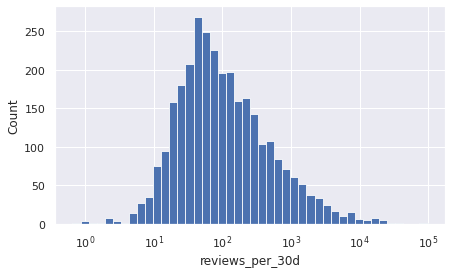

In [67]:
#Построим гистограмму, слишком большой разброс, попробуем логарифмическое масштабирование
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(dsn.reviews_per_30d, log_scale=True, alpha=1)

In [68]:
#Похоже наша целевая переменная распределена по Пуассону, с длинным хвостом с очень сильным разбросом
#Большая часть значений между 10 и 1000

Наша задача это подать на вход нашим моделям датасет с 3-мя столбцами, каждый содержит уникальный для этой игры таг, и получить на выходе класс успешности этой игры. У нас есть "словарь" всех уникальных тагов в нашем датасете и каждая колонка игры с тагом может принять одно из этих значений, при этом в комбинации из 3-х тагов для 1-й игры, они могут быть только уникальны.

Однако одно и то же значение может встретиться много раз в рамках 1 колонки по всему датасету. Грубо говоря у нас словарь из уникальных слов и они могут втретится в датасете случайно с повторениями в каждой колонке, однако никогда они не повторятся для 1 ряда, то есть по сути у нас 3 одинаковых категориальных переменных, однако с тем правилом, что они не могут поторить свои значения в рамках одного ряда. 

Как категориальные переменные, перед подачей в модель их нужно закодировать. У нас 3 категориальные переменные, которые могут каждая принимать 400+ значений, и порядок нам не важен.

<Axes: >

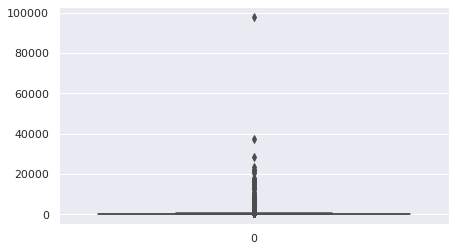

In [69]:
#Но пока, давайте поисследуем еще целевую переменную, построим boxplot
sns.set(rc={'figure.figsize':(7,4)})
sns.boxplot(dsn.reviews_per_30d)

<Axes: >

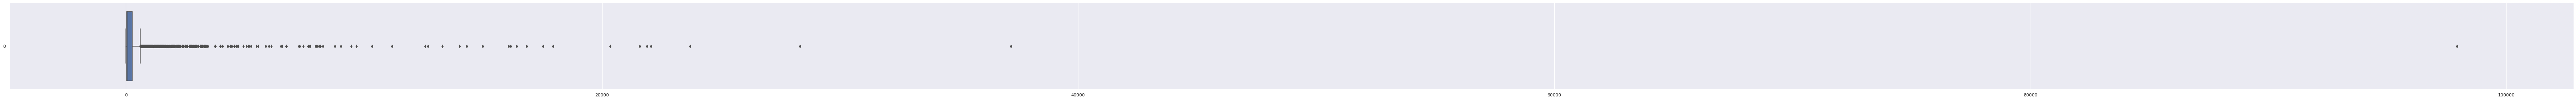

In [70]:
#Явно у нас серьезные проблемы с выбросами, давайте перевернем график
sns.set(rc={'figure.figsize':(115,4)})
sns.boxplot(dsn.reviews_per_30d, orient='horizontal')

<Axes: xlabel='reviews_per_30d', ylabel='Count'>

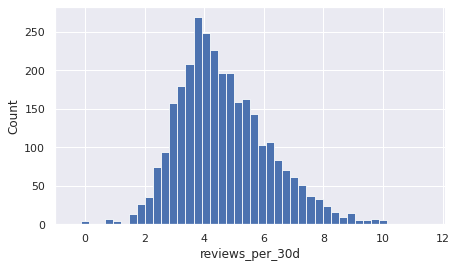

In [71]:
#Я решил не избавляться от выбросов, так как мы можем потерять ценную информацию об успешных играх,
#а проблему слишком большого диапазона мы разрешим логарифмированием целевой переменной
y_log = np.log(dsn.reviews_per_30d)
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(y_log, alpha=1)

In [72]:
#Я решил не избавляться от выбросов, так как мы можем потерять ценную информацию об успешных играх
# опишем логаримированную целевую переменную
y_log = np.log(dsn.reviews_per_30d)

y_log.describe()

count    3050.000000
mean        4.643745
std         1.545644
min        -0.425268
25%         3.581450
50%         4.415319
75%         5.562262
max        11.491885
Name: reviews_per_30d, dtype: float64

In [73]:
# Логарифмированная целевая переменная принимает отрицательные значения в минимуме
# так как минимум ее в целом слишком мал, как видим ниже
dsn.reviews_per_30d.describe()

count     3050.000000
mean       507.210433
std       2512.158158
min          0.653595
25%         35.925620
50%         82.708220
75%        260.411220
max      97917.948718
Name: reviews_per_30d, dtype: float64

<Axes: >

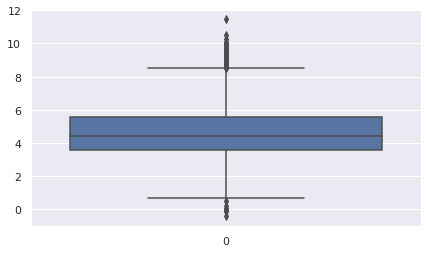

In [74]:
#А теперь построим boxplot
sns.set(rc={'figure.figsize':(7,4)})
sns.boxplot(y_log)

<Axes: >

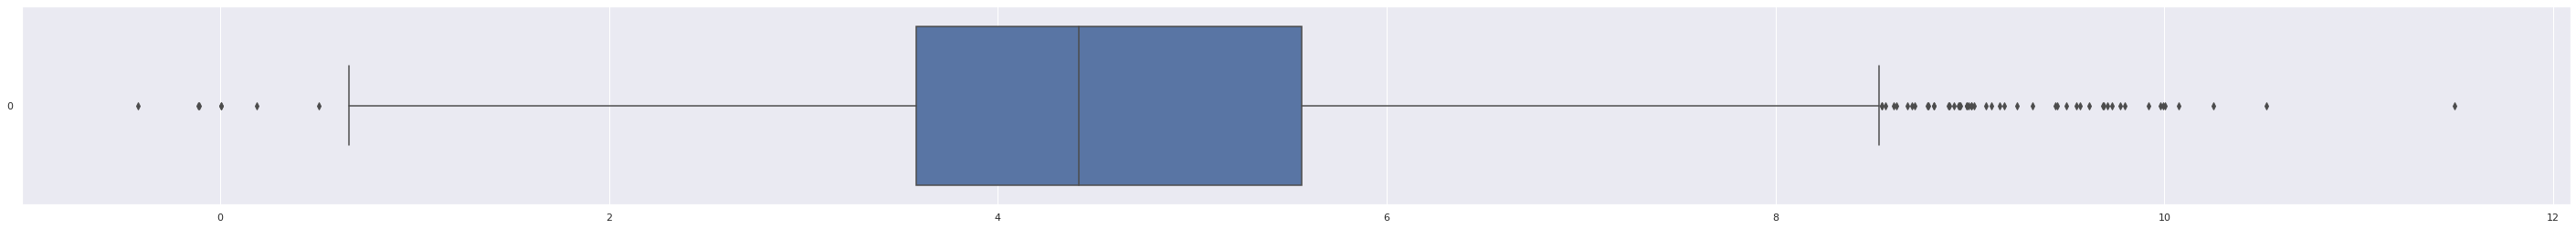

In [75]:
#Уже лучше,но мы видим что снизу даже есть отрицательные значения, теперь горизонтально
sns.set(rc={'figure.figsize':(50,4)})
sns.boxplot(y_log, orient='horizontal')

<Axes: >

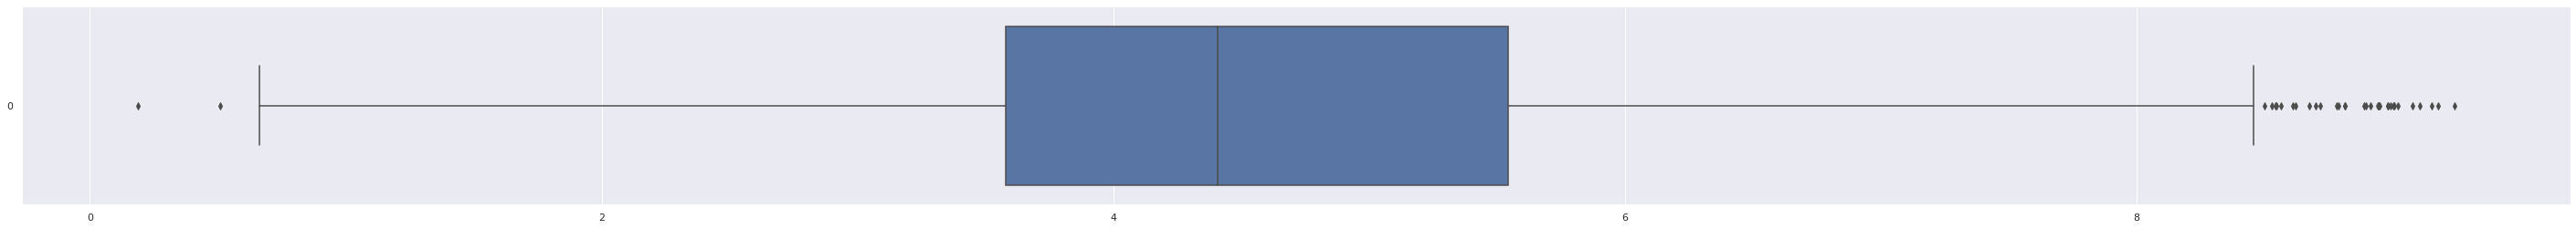

In [76]:
#Давайте попробуем всетаки обкорнать нашу переменную при помощи метода zscore
def zscore_truncate_column(column):
  return column[(np.abs(zscore(column)) < 3)]

def zscore_truncate_ds(ds, column):
  return ds.drop(ds[(np.abs(zscore(column)) > 3)].index)

y_log_z = zscore_truncate_column(y_log)
y_log_z.reset_index(drop=True, inplace=True)

sns.set(rc={'figure.figsize':(50,4)})
sns.boxplot(y_log_z, orient='horizontal')

<Axes: xlabel='reviews_per_30d', ylabel='Count'>

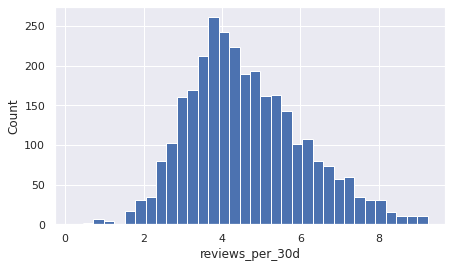

In [77]:
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(y_log_z, alpha=1)

<Axes: >

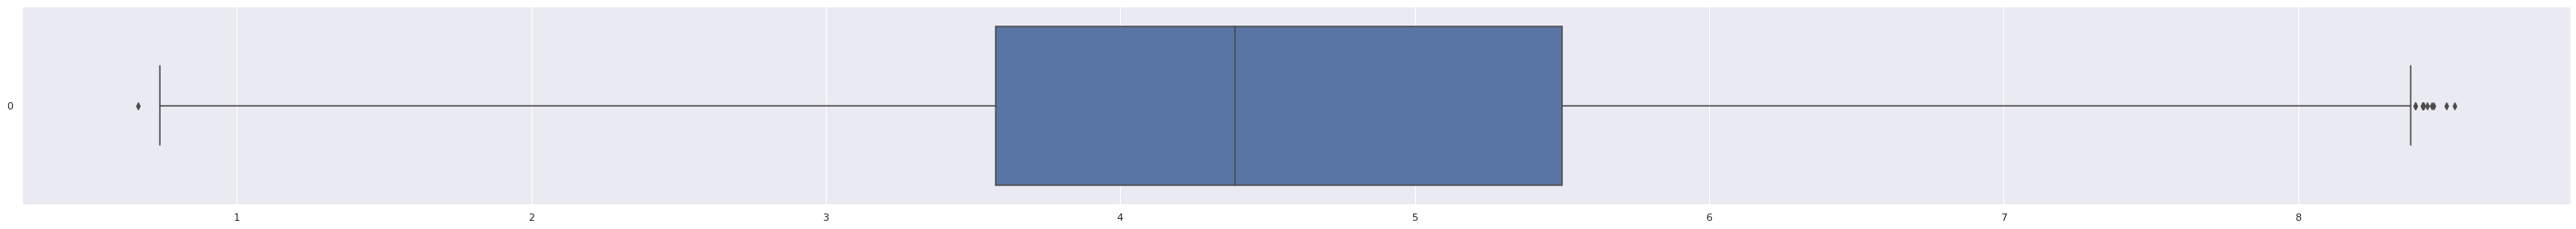

In [78]:
#Распределение можно сказать, похоже на нормальное, теперь попробуем метод квантилей
def quantile_truncate_column(column):
  q1 = column.quantile(0.25)
  q1
  q3 = column.quantile(0.75)
  q3
  iqr = q3 - q1
  max = q3 + 1.5 * iqr
  min = q1 - 1.5 * iqr
  return column[(column < max) & (column > min)]

def quantile_truncate_ds(ds, column):
  q1 = column.quantile(0.25)
  q1
  q3 = column.quantile(0.75)
  q3
  iqr = q3 - q1
  max = q3 + 1.5 * iqr
  min = q1 - 1.5 * iqr
  return ds.drop(ds[(column > max) & (column < min)].index)

y_log_q = quantile_truncate_column(y_log)
y_log_q.reset_index(drop=True, inplace=True)

sns.set(rc={'figure.figsize':(50,4)})
sns.boxplot(y_log_q, orient='horizontal')

<Axes: xlabel='reviews_per_30d', ylabel='Count'>

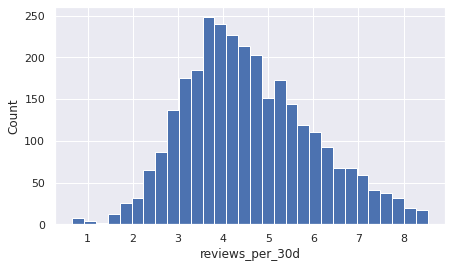

In [79]:
sns.set(rc={'figure.figsize':(7,4)})
sns.histplot(y_log_q, alpha=1)

In [80]:
#Выглядит еще нормальнее, и все отрицательные значения удалены,
# однако давайте проверим сколько информации удалил каждый способ
print(f"original : {y_log.shape}")
print(f"Zscore : {y_log_z.shape}")
print(f"Quantile : {y_log_q.shape}") 

original : (3050,)
Zscore : (3024,)
Quantile : (2993,)


In [81]:
#Метод zscore не так сильно причесывает наши данные, однако оставляет больше информации, что нам вообще-то очень важно
# давайте просто обрежем все те значения где у нас наша логарифмическая переменная принимает отрицательные значения,
# вместо того чтобы делать полный обрез выбросов одним из способов
y_log.describe()

count    3050.000000
mean        4.643745
std         1.545644
min        -0.425268
25%         3.581450
50%         4.415319
75%         5.562262
max        11.491885
Name: reviews_per_30d, dtype: float64

In [82]:
y_log[y_log < 0]

2163   -0.425268
2166   -0.107359
2167   -0.113329
Name: reviews_per_30d, dtype: float64

In [83]:
# Обрежем все отрицательные значения
y_log_pos = y_log[y_log > 0]
y_log_pos.describe()

count    3047.000000
mean        4.648529
std         1.538853
min         0.003339
25%         3.584765
50%         4.417107
75%         5.562763
max        11.491885
Name: reviews_per_30d, dtype: float64

<Axes: xlabel='quants', ylabel='reviews_per_30d'>

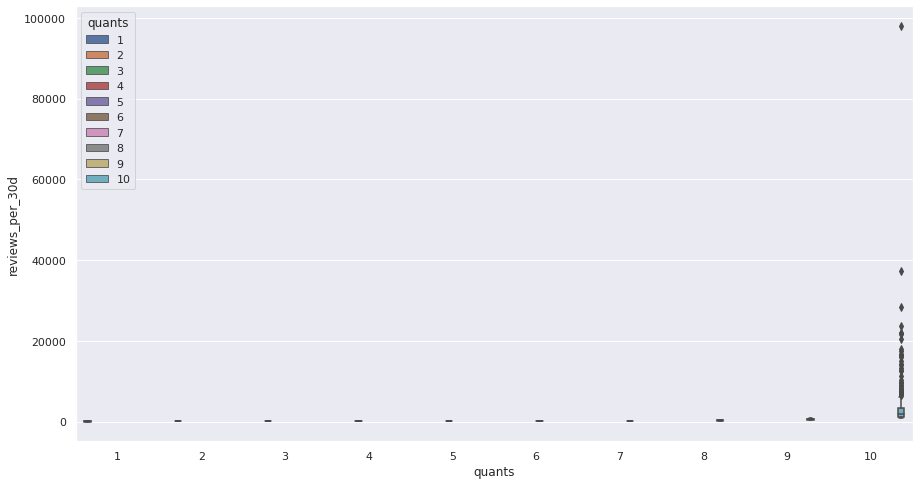

In [84]:
#Разобьем нашу целевую переменную на квантили и посмотрим, как она делится на категории
dst = dsn.copy()

price_bins = dst.reviews_per_30d.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dst["quants"] = pd.cut(dst.reviews_per_30d, price_bins, labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], right=True, include_lowest=True)
plt.figure(figsize=(15, 8))
sns.boxplot(data = dst, x = 'quants', y = 'reviews_per_30d', hue='quants')

In [85]:
#Слишком большой диапазон, нужно логарифмировать, однако уже виден сильный дисбаланс
#значений целевой
for i in range(1, 11):
  print(f"Mean of quantile {i} - {dst[dst.quants==f'{i}']['reviews_per_30d'].mean().round(2)}")

Mean of quantile 1 - 11.66
Mean of quantile 2 - 23.4
Mean of quantile 3 - 35.69
Mean of quantile 4 - 49.62
Mean of quantile 5 - 69.78
Mean of quantile 6 - 102.08
Mean of quantile 7 - 158.35
Mean of quantile 8 - 264.45
Mean of quantile 9 - 548.97
Mean of quantile 10 - 3808.11


In [86]:
# Можно охарактеризовать все что ниже  6 - как плохо,
# а 7 - 8 - нормально, 9 - хорошо, а 10 - отлично 
print(f"Min of quantile {10} - {dst[dst.quants==f'{10}']['reviews_per_30d'].min().round(2)}")

Min of quantile 10 - 852.39


<Axes: xlabel='quants', ylabel='reviews_per_30d'>

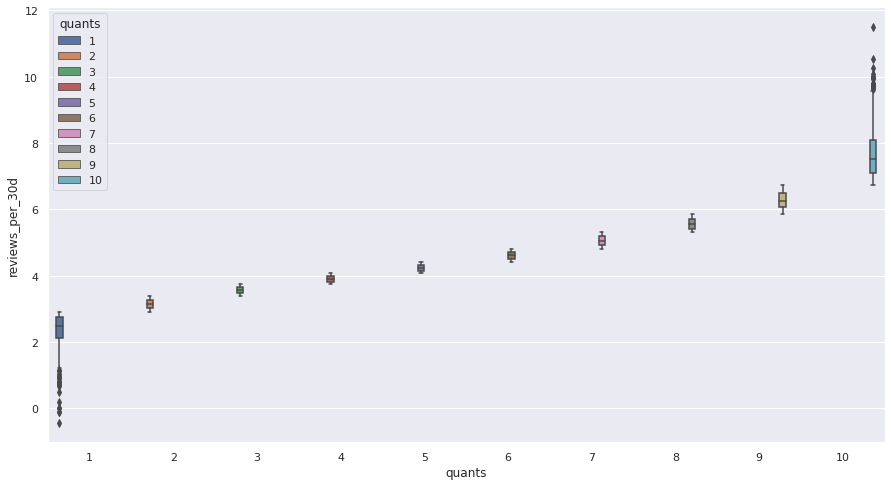

In [87]:
#Давайте логарифмируем
dst = dsn.copy()

dst['reviews_per_30d'] = np.log(dst['reviews_per_30d'])

price_bins = dst.reviews_per_30d.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dst["quants"] = pd.cut(dst.reviews_per_30d, price_bins, labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], right=True, include_lowest=True)
plt.figure(figsize=(15, 8))
sns.boxplot(data = dst, x = 'quants', y = 'reviews_per_30d', hue='quants')

<Axes: xlabel='quants', ylabel='reviews_per_30d'>

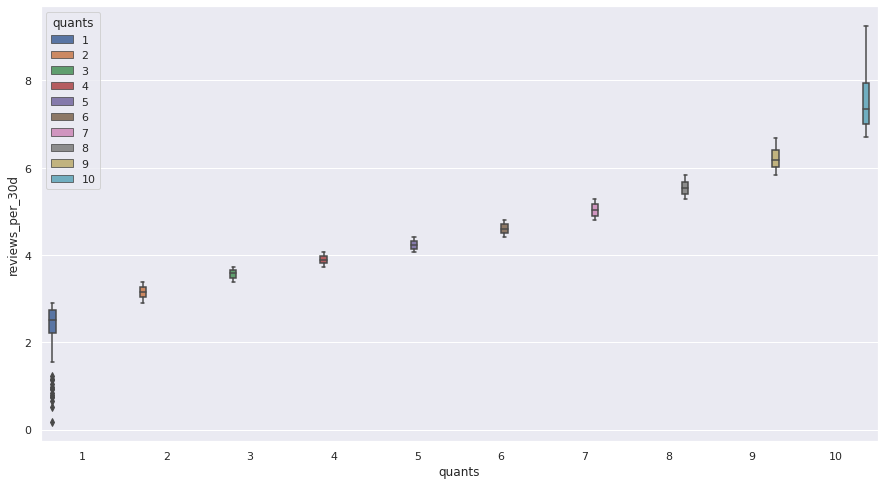

In [88]:
#Теперь лучше, видно что большая часть данных у нас имеет слабую волатильность,
#и только по краям, особенно на 10-м квантиле диапазон значений сильно возрастает
# давайте попробуем без выбросов, сначала zscore
dst_z = zscore_truncate_ds(dst, dst['reviews_per_30d'])

price_bins = dst_z.reviews_per_30d.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dst_z["quants"] = pd.cut(dst_z.reviews_per_30d, price_bins, labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], right=True, include_lowest=True)
plt.figure(figsize=(15, 8))
sns.boxplot(data = dst_z, x = 'quants', y = 'reviews_per_30d', hue='quants')

<Axes: xlabel='quants', ylabel='reviews_per_30d'>

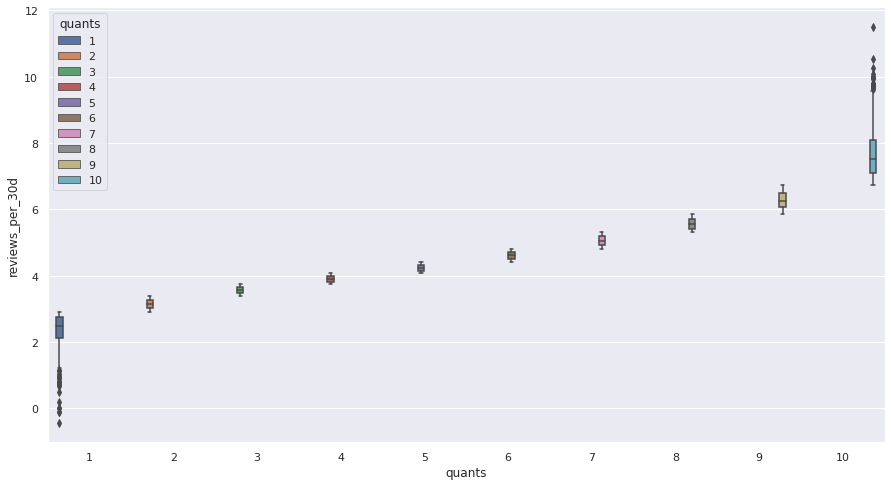

In [89]:
#Много наших бесценных супер-успешных игр было нещадно порезано zscore
#Определенно нехорошо, протестируем quantile
dst_q = quantile_truncate_ds(dst, dst['reviews_per_30d'])

price_bins = dst_q.reviews_per_30d.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dst_q["quants"] = pd.cut(dst_q.reviews_per_30d, price_bins, labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], right=True, include_lowest=True)
plt.figure(figsize=(15, 8))
sns.boxplot(data = dst_q, x = 'quants', y = 'reviews_per_30d', hue='quants')

In [90]:
#Как видим, больше супер-успешных игр осталось
#Мы будем пробовать использовать эти квантили для определения нашего класса,
#который будет определять успех игры
dst = dsn.copy()

quants = dst.reviews_per_30d.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
dst["rating"] = pd.cut(dst.reviews_per_30d, quants, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], right=True, include_lowest=True)

# Работа с моделями

## Подготовка данных к работе с моделями

Составим итоговый датасет, который по подадим в модель.


In [91]:
#Используем последние 2 квантиля, как бинарный класс определяющий "успех"
dst['is_successful'] = dst.rating > 8
dst['is_successful'].sum()

610

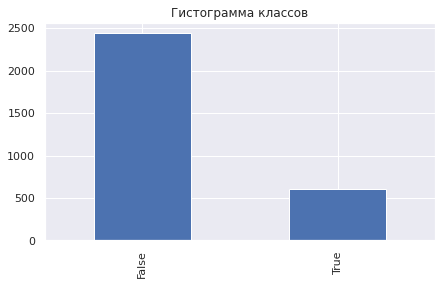

In [92]:
#Взглянем на дсибаланс
pd.value_counts(dst['is_successful']).plot.bar()
plt.title('Гистограмма классов')
plt.show()

In [93]:
dst['is_successful'].sum()/(dst['is_successful'] == False).sum()

0.25

In [94]:
dsn = dst

In [95]:
#Еще раз составим словарь из всех слов первых трех тагов наших игр
#Мы уже это делали, но манипуляции по удалению после того раза могли
#уменьшить количество наших тагов
all_tags = []

for tag_list in dsn.tags_list:
  all_tags += tag_list[:3]

all_tags = list(set(all_tags))
len(all_tags)

369

In [96]:
# Теперь сделаем список из всех списков тагов для каждой игры
all_lists_of_tags = []
for lst in dsn.tags_list:
  all_lists_of_tags.append(lst[:3])

len(all_lists_of_tags)

3050

In [97]:
all_lists_of_tags[:5]

[['Free to Play', 'Battle Royale', 'Multiplayer'],
 ['Action', 'Adventure', 'Singleplayer'],
 ['Souls-like', 'Relaxing', 'Dark Fantasy'],
 ['Open World', 'Action', 'Multiplayer'],
 ['Racing', 'Open World', 'Driving']]

Давайте создадим наш итоговый датасет, который мы затем будет подавать в наши модели классификации.

In [98]:
X = pd.DataFrame(all_lists_of_tags, columns=['tag1', 'tag2', 'tag3'])

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3050 entries, 0 to 3049
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag1    3050 non-null   object
 1   tag2    3050 non-null   object
 2   tag3    3050 non-null   object
dtypes: object(3)
memory usage: 71.6+ KB


In [99]:
X.head()

,tag1,tag2,tag3
0,Free to Play,Battle Royale,Multiplayer
1,Action,Adventure,Singleplayer
2,Souls-like,Relaxing,Dark Fantasy
3,Open World,Action,Multiplayer
4,Racing,Open World,Driving


In [100]:
y = dsn.is_successful.replace({True : 1, False : 0})
y

0       1
1       1
2       1
3       1
4       1
       ..
3045    1
3046    1
3047    1
3048    1
3049    1
Name: is_successful, Length: 3050, dtype: int64

In [101]:
encoder = ce.TargetEncoder(return_df=True, smoothing = 10)

X = encoder.fit_transform(X, y)

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2440, 3), (610, 3), (2440,), (610,))

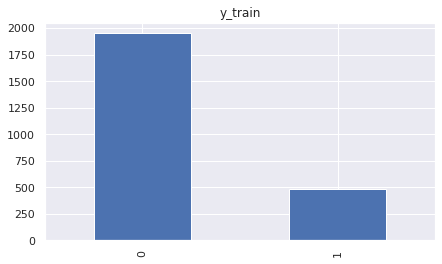

In [103]:
pd.value_counts(y_train).plot.bar()
plt.title('y_train')
plt.show()

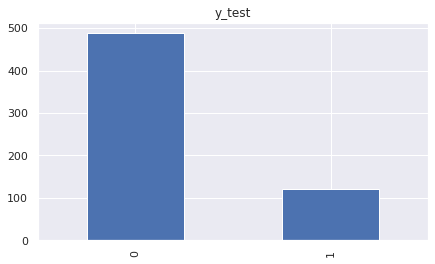

In [104]:
pd.value_counts(y_test).plot.bar()
plt.title('y_test')
plt.show()

In [105]:
X_train.tag1

177     0.210210
3007    0.270230
2955    0.345940
2389    0.261258
2602    0.244699
          ...   
2541    0.164706
1344    0.208399
2188    0.357708
3       0.662418
1997    0.137623
Name: tag1, Length: 2440, dtype: float64

In [106]:
X_train.head()

,tag1,tag2,tag3
177,0.210210,0.255002,0.429923
3007,0.270230,0.325690,0.126232
2955,0.345940,0.389890,0.244699
2389,0.261258,0.130153,0.211574
2602,0.244699,0.272970,0.171630


In [107]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2440 entries, 177 to 1997
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tag1    2440 non-null   float64
 1   tag2    2440 non-null   float64
 2   tag3    2440 non-null   float64
dtypes: float64(3)
memory usage: 76.2 KB


##Обучение и тестирование моделей классификации

Обучаем, тестируем и оцениваем модели классификации. Не забываем, что у нас дисабаланс классов 80 к 20, и классификация у нас бинарная, поэтому метрика accuracy - бесполезна.
Она просто будет равна пропорции наших классов, если мы просто все данные классифицируем как мажоритарный класс - мы получим показатель accuracy равный пропорции этого класса в отношении к миноритарному. Мы используем другие показатели, описанные и осуществленные в коде ниже в ячейке

In [108]:
#Создадим датасет для оценки итоговых результатов наших моделей 
results = []

### Logistic regression

f1 score 0.5092024539877301
Precision:  0.4068627450980392
Recall:  0.680327868852459
Matthews corrcoef:  0.3665847203459963


,Actual,Predicted,Probability [0],Probability [1]
2923,1,0,0.685026,0.314974
2725,0,1,0.423876,0.576124
2585,0,1,0.308864,0.691136
1345,0,0,0.679091,0.320909
1531,0,0,0.733220,0.266780


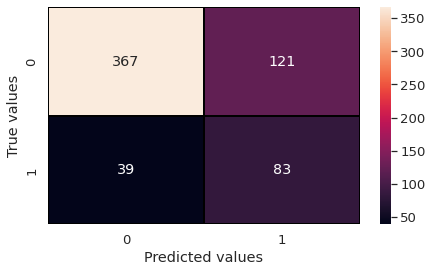

In [109]:
lgr = LogisticRegression(random_state=42, class_weight={0:1, 1:4})

lgr.fit(X_train, y_train);

model = lgr

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'Logistic regression',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,
                           'Probability [0]' : y_prob[:, 0], 'Probability [1]' : y_prob[:, 1]})
compare_ds.head()

### Decision tree

Best params:  {'max_depth': 30}
f1 score 0.35856573705179284
Precision:  0.3488372093023256
Recall:  0.36885245901639346
Matthews corrcoef:  0.19269650777501987


,Actual,Predicted,Probability [0],Probability [1]
2923,1,0,1.0,0.0
2725,0,0,1.0,0.0
2585,0,0,1.0,0.0
1345,0,0,1.0,0.0
1531,0,0,1.0,0.0


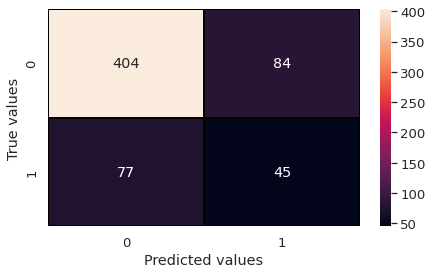

In [110]:
dtr = tree.DecisionTreeClassifier(class_weight={0:1, 1:4})

parameters = {
    'max_depth': [10, 20, 30, 50, 100, 200],
};

grid_search_dtr = GridSearchCV(estimator = dtr, scoring='f1_weighted', param_grid = parameters, cv=10)

grid_search_dtr.fit(X_train, y_train);

print('Best params: ', grid_search_dtr.best_params_)

model = grid_search_dtr

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'Decision Tree Classifier',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,
                           'Probability [0]' : y_prob[:, 0], 'Probability [1]' : y_prob[:, 1]})
compare_ds.head()

### Gaussian Bayes

f1 score 0.34196891191709844
Precision:  0.4647887323943662
Recall:  0.27049180327868855
Matthews corrcoef:  0.2402560324809437


,Actual,Predicted,Probability [0],Probability [1]
2923,1,0,0.719140,0.280860
2725,0,0,0.795930,0.204070
2585,0,0,0.543314,0.456686
1345,0,0,0.951791,0.048209
1531,0,0,0.965589,0.034411


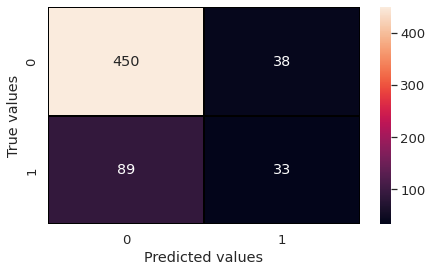

In [111]:
cnb = GaussianNB()

model = cnb.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'Gaussian Naive Bayes',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,
                           'Probability [0]' : y_prob[:, 0], 'Probability [1]' : y_prob[:, 1]})
compare_ds.head()

### K-Nearest neighbors

Best params:  {'n_neighbors': 10}
f1 score 0.44565217391304346
Precision:  0.6612903225806451
Recall:  0.3360655737704918
Matthews corrcoef:  0.3879001234451698


,Actual,Predicted,Probability [0],Probability [1]
2923,1,0,1.0,0.0
2725,0,0,0.8,0.2
2585,0,0,0.8,0.2
1345,0,0,1.0,0.0
1531,0,0,1.0,0.0


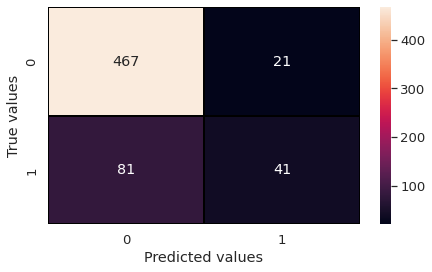

In [112]:
knn = KNeighborsClassifier()

parameters = {
    'n_neighbors' : [1, 5, 10, 20],
};

grid_search_knn = GridSearchCV(estimator = knn, scoring='f1_weighted', param_grid = parameters, cv=10)

grid_search_knn.fit(X_train, y_train);

print('Best params: ', grid_search_knn.best_params_)

model = grid_search_knn

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'K-Nearest neighbors',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,
                           'Probability [0]' : y_prob[:, 0], 'Probability [1]' : y_prob[:, 1]})
compare_ds.head()

### SVC

Best params:  {'C': 15, 'gamma': 0.001, 'kernel': 'rbf'}
f1 score 0.47413793103448276
Precision:  0.5
Recall:  0.45081967213114754
Matthews corrcoef:  0.35178118198675723


,Actual,Predicted
2923,1,0
2725,0,0
2585,0,1
1345,0,0
1531,0,0


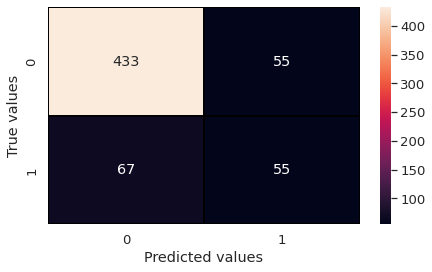

In [113]:
svc = SVC(class_weight={0:1, 1:4})

parameters = {
    'C':[1, 5, 10, 15],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf'],
};

grid_search_svc = GridSearchCV(estimator = svc, scoring='f1_weighted', param_grid = parameters, cv=10)

grid_search_svc.fit(X_train, y_train);

print('Best params: ', grid_search_svc.best_params_)

model = grid_search_svc

y_pred = model.predict(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'SVC',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,})
compare_ds.head()

### Random forest

Best params:  {'max_depth': 30, 'n_estimators': 150}
f1 score 0.4423076923076923
Precision:  0.5348837209302325
Recall:  0.3770491803278688
Matthews corrcoef:  0.33917015299987374


,Actual,Predicted,Probability [0],Probability [1]
2923,1,0,0.986667,0.013333
2725,0,0,0.773333,0.226667
2585,0,0,0.780000,0.220000
1345,0,0,0.900000,0.100000
1531,0,0,0.966667,0.033333


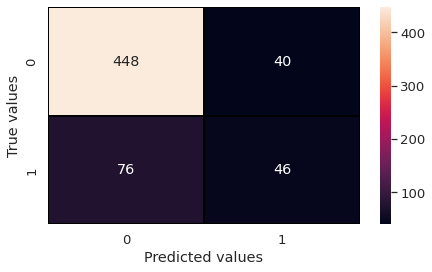

In [114]:
rfc = RandomForestClassifier(class_weight={0:1, 1:4})

parameters = {
    'max_depth': [5, 10, 15, 20, 30, 50],
    'n_estimators': [10, 20, 30, 50, 60, 70, 80, 90, 100, 150, 200, 300]
};

grid_search_rfc = GridSearchCV(estimator = rfc, scoring='f1_weighted', param_grid = parameters, cv=10)

grid_search_rfc.fit(X_train, y_train);

print('Best params: ', grid_search_rfc.best_params_)

model = grid_search_rfc

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#Harmonic mean between precision and recall
# f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'Random forest classifier',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

compare_ds = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred,
                           'Probability [0]' : y_prob[:, 0], 'Probability [1]' : y_prob[:, 1]})
compare_ds.head()

## Нейронная сеть

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               2048      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 265,217
Trainable params: 265,217
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
61/61 [==============================] - 2s 10ms/step - loss: 0.5380 - val_loss: 0.5093
Epoch 2/40
61/61 [==============================] - 0s 8ms/step - loss: 0.4876 - val_loss: 0.4570
Epoch 3/40
61/61 [==============================] - 0s 7ms/step - loss: 0.4246 - val_loss: 0.4215
Epoch 4/40
61/61 [=

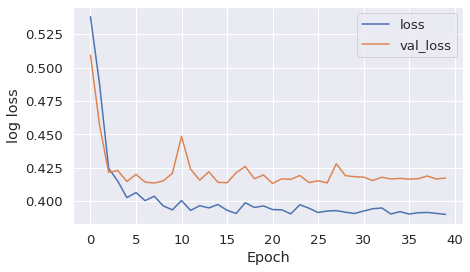

In [115]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=3))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

history = model.fit(
    X_train,
    y_train,
    epochs=40,
    validation_split = 0.2)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('log loss')
plt.legend()
plt.grid(True)

20/20 [==============================] - 0s 3ms/step
f1 score 0.43523316062176165
Precision:  0.5915492957746479
Recall:  0.3442622950819672
Matthews corrcoef:  0.3552722182430976


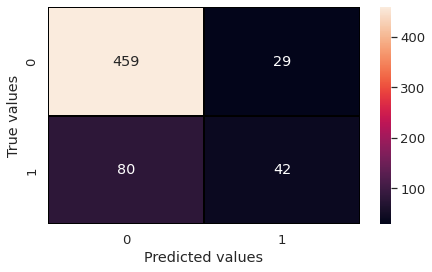

In [116]:
y_pred = model.predict(X_test)
y_pred = [1 if i > 0.5 else 0 for i in y_pred]

sns.set(font_scale=1.2)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#f1 score: Среднее гармоническое между точностью и полнотой
print('f1 score', f1_score(y_test, y_pred))
print('Precision: ', tp/(tp + fp))
print('Recall: ', tp/(tp + fn))
#It’s a correlation between predicted classes and ground truth
#Отражает корреляцию между предсказаниями и правдой
print('Matthews corrcoef: ', matthews_corrcoef(y_test, y_pred))

results.append([
                 'Neural network',
                 f1_score(y_test, y_pred),
                 tp/(tp + fp), tp/(tp + fn),
                 matthews_corrcoef(y_test, y_pred)
               ])

sns.heatmap(cm, 
            annot=True, 
            fmt = '.3g',
            linewidths=0.1,
            linecolor='black',
            );
plt.xlabel('Predicted values')
plt.ylabel('True values');

# Итоговая оценка алгоритмов

In [117]:
results = pd.DataFrame(data=results, columns=[['model_name','f1_score', 'precision', 'recall', 'matthews_corr_coef']])
results

,model_name,f1_score,precision,recall,matthews_corr_coef
0,Logistic regression,0.509202,0.406863,0.680328,0.366585
1,Decision Tree Classifier,0.358566,0.348837,0.368852,0.192697
2,Gaussian Naive Bayes,0.341969,0.464789,0.270492,0.240256
3,K-Nearest neighbors,0.445652,0.661290,0.336066,0.387900
4,SVC,0.474138,0.500000,0.450820,0.351781
5,Random forest classifier,0.442308,0.534884,0.377049,0.339170
6,Neural network,0.435233,0.591549,0.344262,0.355272


# Сохранение модели

In [118]:
model = grid_search_knn.estimator.fit(X, y)
# Its important to use binary mode 
knnPickle = open('knnpickle_file', 'wb')
      
# source, destination 
pickle.dump(knn, knnPickle)  

# close the file
knnPickle.close()